# One Class Support Vector Machines

## Importing Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [2]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [3]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [4]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [11]:
# fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")

train_end = 7200 #(5 days)
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS
# First anomalies after infection
min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
tpr = []

for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    ##################################################################
    # Finding Infection Time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
        ##################################################################
        # Filing in missing data
        temp_value_fw = temp_value.fillna(method='ffill') # foward fill
        temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill

        # Time Delay Embedding
        temp_tde = tde.tde(temp_value_bw) # using the tde file
        temp_tde = temp_tde.T # transporting the data

        ##################################################################
        # Fit the Data on the first 3 days (3*24*60) 
        model.fit(temp_tde[:train_end+1,:])

        # Predict the Data
        predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
        predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data

        # Scores
        scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
        scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data

        threshold = model.offset_

        ##################################################################
        # Combine training and testing scores and predictions
        combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
        combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)

        time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift

        # Minimum score
        min_score = scores_train_data.min()

        # Find the indices of the anomalies
        anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
        time_2 = anomaly_indices + (shift) # shifting the time for plotting
        
        ##################################################################
        # Find the index at which the first score is less than min_score
        boolean = combined_scores < min_score
        anom_train = np.argmax(boolean) #+shift
        anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time 

        # Get the corresponding value
        value = combined_scores[anom_train]
        value_1 = combined_scores[anom_infec-shift]

        # Calculating the time first anomaly was found after training and infection
        time_aft_train = (anom_train + shift) - train_end
        time_aft_infection = anom_infec - infection_time

        # Calculating the amount of false negatives (between end of train and infection time)
        count_false_neg = np.count_nonzero(boolean[train_end:infection_time])

        # Calculating the amount of true positives (infection time)
        count_true_pos = np.count_nonzero(boolean[infection_time:]) 

        # Calculating true positive rate
        # Check if the denominator is zero
        if (count_true_pos + count_false_neg) == 0:
            print("N/A")
            continue  # Skip this iteration and move to the next number
        TPR = count_true_pos / (count_true_pos + count_false_neg)
        
        ##################################################################
        # Print Values
        print("Minimum Score: ", min_score)
        print("After Training Min: ", anom_train+shift)
        print("After Infection Min: ", anom_infec)
        print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
        print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
        print(f"True Positve Rate: {TPR*100}%")

        ##################################################################
        # Appending to Lists
        min_scores.append(min_score)
        first_anom_train.append(time_aft_train)
        first_anom_inf.append(time_aft_infection)
        score_train.append(value)
        score_infec.append(value_1)
        tpr.append(TPR)
    
    else:
        print(f"No match found for mouse '{names}'")
   

Found 'CC006-315' and its infection value is '10300'
Minimum Score:  421.2324136337255
After Training Min:  11049
After Infection Min:  11049
First anomaly found after training: 3849 minutes with score 389.21973137373834
First anomaly found after infection: 749 minutes with score 389.21973137373834
True Positve Rate: 100.0%
Found 'CC006-316' and its infection value is '10300'
Minimum Score:  435.68503381684445
After Training Min:  10464
After Infection Min:  10464
First anomaly found after training: 3264 minutes with score 383.8489128994704
First anomaly found after infection: 164 minutes with score 383.8489128994704
True Positve Rate: 99.06222681395533%
Found 'CC006-317' and its infection value is '10300'
Minimum Score:  411.4133279779127
After Training Min:  12667
After Infection Min:  12667
First anomaly found after training: 5467 minutes with score 380.27826118432756
First anomaly found after infection: 2367 minutes with score 380.27826118432756
True Positve Rate: 100.0%
Found 'CC0

Minimum Score:  201.79012843331373
After Training Min:  16325
After Infection Min:  16325
First anomaly found after training: 9125 minutes with score 200.16611150736367
First anomaly found after infection: 2125 minutes with score 200.16611150736367
True Positve Rate: 100.0%
Found 'CC002-558' and its infection value is '14200'
Minimum Score:  325.66180330120756
After Training Min:  8422
After Infection Min:  14566
First anomaly found after training: 1222 minutes with score 160.53621948582975
First anomaly found after infection: 366 minutes with score 291.16868492608273
True Positve Rate: 98.92011147236414%
Found 'CC002-559' and its infection value is '14200'
Minimum Score:  257.7441911007911
After Training Min:  8424
After Infection Min:  14580
First anomaly found after training: 1224 minutes with score 92.19806872582092
First anomaly found after infection: 380 minutes with score 253.9266655965505
True Positve Rate: 10.0%
Found 'CC015-390' and its infection value is '14200'
N/A
Found 'C

Minimum Score:  251.80354354896497
After Training Min:  9517
After Infection Min:  18601
First anomaly found after training: 2317 minutes with score 249.5231855278438
First anomaly found after infection: 7301 minutes with score 240.97708190978415
True Positve Rate: 55.294117647058826%
Found 'CC025-598' and its infection value is '11300'
N/A
Found 'CC025-599' and its infection value is '11300'
Minimum Score:  405.3295159205656
After Training Min:  11338
After Infection Min:  11338
First anomaly found after training: 4138 minutes with score 379.1242863382556
First anomaly found after infection: 38 minutes with score 379.1242863382556
True Positve Rate: 75.75757575757575%
Found 'CC025-600' and its infection value is '11300'
Minimum Score:  438.072448013056
After Training Min:  8133
After Infection Min:  11348
First anomaly found after training: 933 minutes with score 432.9922399946075
First anomaly found after infection: 48 minutes with score 413.14689790856977
True Positve Rate: 90.81632

Minimum Score:  260.8588647785094
After Training Min:  14345
After Infection Min:  14345
First anomaly found after training: 7145 minutes with score 196.0625482599346
First anomaly found after infection: 45 minutes with score 196.0625482599346
True Positve Rate: 94.33962264150944%
Found 'CC019-1452' and its infection value is '14300'
Minimum Score:  163.18121214825055
After Training Min:  14348
After Infection Min:  14348
First anomaly found after training: 7148 minutes with score 106.88059091409218
First anomaly found after infection: 48 minutes with score 106.88059091409218
True Positve Rate: 34.04255319148936%
Found 'CC023-567' and its infection value is '14300'
Minimum Score:  297.0389003272187
After Training Min:  8096
After Infection Min:  14365
First anomaly found after training: 896 minutes with score 254.81954845290898
First anomaly found after infection: 65 minutes with score 200.4392117792878
True Positve Rate: 56.12244897959183%
Found 'CC023-568' and its infection value is 

Minimum Score:  204.7639683094095
After Training Min:  10046
After Infection Min:  10046
First anomaly found after training: 2846 minutes with score 170.67558631406064
First anomaly found after infection: 46 minutes with score 170.67558631406064
True Positve Rate: 31.57894736842105%
Found 'CC019-1514' and its infection value is '10000'
N/A
Found 'CC024-363' and its infection value is '10000'
Minimum Score:  370.5210895921715
After Training Min:  8915
After Infection Min:  10055
First anomaly found after training: 1715 minutes with score 360.08783479554506
First anomaly found after infection: 55 minutes with score 235.77611753711142
True Positve Rate: 99.1193306913254%
Found 'CC024-364' and its infection value is '10000'
Minimum Score:  514.0594250712094
After Training Min:  10059
After Infection Min:  10059
First anomaly found after training: 2859 minutes with score 413.54636161946524
First anomaly found after infection: 59 minutes with score 413.54636161946524
True Positve Rate: 26.56

Minimum Score:  271.3127066764117
After Training Min:  8266
After Infection Min:  10100
First anomaly found after training: 1066 minutes with score 263.15240216852465
First anomaly found after infection: 0 minutes with score 739.0486282922167
True Positve Rate: 0.0%
Found 'CC051-615' and its infection value is '10100'
Minimum Score:  288.1981617498287
After Training Min:  9891
After Infection Min:  10247
First anomaly found after training: 2691 minutes with score 253.6155136965765
First anomaly found after infection: 147 minutes with score 281.3137722459974
True Positve Rate: 97.98464491362763%
Found 'CC053-366' and its infection value is '10100'
N/A
Found 'CC053-370' and its infection value is '10100'
Minimum Score:  239.75382156155808
After Training Min:  12344
After Infection Min:  12344
First anomaly found after training: 5144 minutes with score 232.780557250347
First anomaly found after infection: 2244 minutes with score 232.780557250347
True Positve Rate: 100.0%
Found 'CC053-371'

In [7]:
# Make all lists into arrays
ms = np.array(min_scores)
fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)
st = np.array(score_train)
si = np.array(score_infec)
tprs = np.array(tpr)

In [8]:
# Create the data for the table (calculates statistics)
data = {
    'column_1': [round(np.mean(ms),2), round(np.mean(fat),2), round(np.mean(fai),2), round(np.mean(st),2), round(np.mean(si),2), round(np.mean(tprs)*100,2)],
    'column_2': [round(np.std(ms),2), round(np.std(fat),2), round(np.std(fai),2), round(np.std(st),2), round(np.std(si),2), round(np.std(tprs)*100,2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2), round(np.percentile(tprs, 25)*100,2)],
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2), round(np.percentile(tprs, 50)*100,2)],
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2), round(np.percentile(tprs, 75)*100,2)]
}

In [9]:
# Create a DataFrame
df = pd.DataFrame(data)

# Set row names (index)
row_names = ['Minimum Score', 'First Anomaly Time After Training', 'First Anomaly Time After Infection', 'First Anomaly Score After Training', 'First Anomaly Score After Infection  ', 'True Positive Rate']
df.index = row_names

# Set column names
column_names = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns = column_names

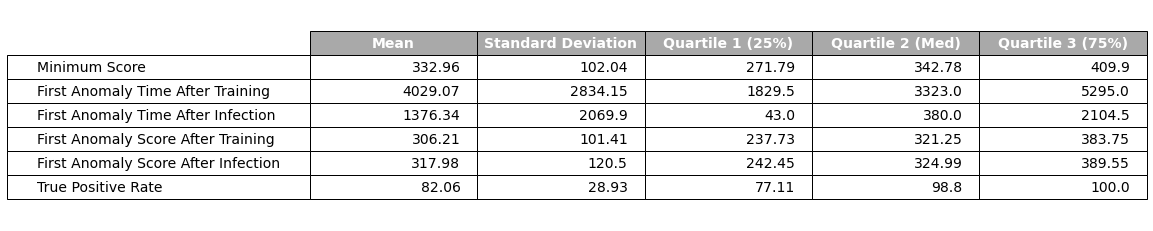

In [10]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns):
    cell = table[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
plt.savefig('table_statistics_5days.png', bbox_inches='tight', facecolor='white')


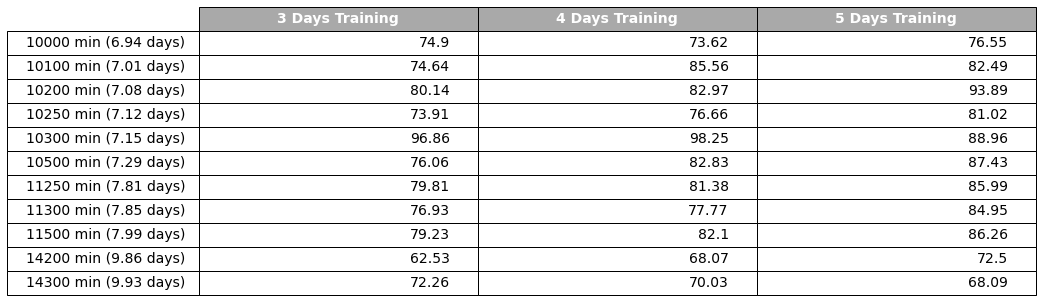

In [18]:
averages = {
    'column 1': [74.90, 74.64, 80.14, 73.91, 96.86, 76.06, 79.81, 76.93, 79.23, 62.53, 72.26],
    'column 2': [73.62, 85.56, 82.97, 76.66, 98.25, 82.83, 81.38, 77.77, 82.10, 68.07, 70.03],
    'column 3': [76.55, 82.49, 93.89, 81.02, 88.96, 87.43, 85.99, 84.95, 86.26, 72.50, 68.09]
}

averages_df = pd.DataFrame(averages)

#Row Names
row_times = ['10000 min (6.94 days)','10100 min (7.01 days)', '10200 min (7.08 days)','10250 min (7.12 days)','10300 min (7.15 days)','10500 min (7.29 days)', '11250 min (7.81 days)', '11300 min (7.85 days)','11500 min (7.99 days)','14200 min (9.86 days)','14300 min (9.93 days)']
df.index1 = row_times

#Column Names
col_train = ['3 Days Training', '4 Days Training', '5 Days Training']
df.columns1 = col_train


# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=averages_df.values, colLabels=df.columns1, rowLabels=df.index1, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns1):
    cell = table[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
plt.savefig('averages_of_TPR.png', bbox_inches='tight', facecolor='white')
